### example for single satellite in osm time slice

In [2]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const
import glob
from scepter import skynet,obs,tlefinder
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz, ICRS
from matplotlib.gridspec import GridSpec
from matplotlib import animation
import pandas as pd
###reload here
reload(skynet)
reload(obs)

<module 'scepter.obs' from '/Users/h.qiu/scepter/scepter/obs.py'>

In [3]:
osm_file='OSKAR-2.7-Example-Data/example_sky.osm'
sat_pos_file='oskar_radec.npz'

In [ ]:
column_names = ['RA', 'Dec', 'I', 'Q', 'U', 'V', 'freq0', 'spix', 'RM', 'maj', 'min', 'pa']

# Read the file into a DataFrame
df = pd.read_csv(osm_file, comment='#', sep='\s+', names=column_names)

# Display the DataFrame
print(df)

def write_osm(df, file_path):
    with open(file_path, 'w') as f:
        f.write("#\n")
        f.write("#  RA,    Dec,   I,    Q,    U,    V,   freq0, spix,  RM,      maj,      min,      pa\n")
        f.write("# (deg), (deg), (Jy), (Jy), (Jy), (Jy), (Hz), (-), (rad/m^2), (arcsec), (arcsec), (deg)\n")
        f.write("#\n")
        data_str=df.to_csv(sep=' ', index=False, header=False, float_format='%.6g')
        f.write(data_str)

FileNotFoundError: [Errno 2] No such file or directory: 'OSKAR-2.7-Example-Data/example_sky.osm'

In [ ]:
### read time slice satellite positions from the satellite positions notebook
ra=np.load(sat_pos_file)['ra']
dec=np.load(sat_pos_file)['dec']
mjds=np.load(sat_pos_file)['time']
alt=np.load(sat_pos_file)['alt']
az=np.load(sat_pos_file)['az']
dist=np.load(sat_pos_file)['dist']
time = Time(mjds, format='mjd')

### flatten the data 
nsat=ra.shape[-1]
ra=ra.reshape(-1,nsat)
dec=dec.reshape(-1,nsat)
alt=alt.reshape(-1,nsat)
az=az.reshape(-1,nsat)
dist=dist.reshape(-1,nsat)
print(ra.shape,dec.shape,dist.shape)




(2000, 1000) (2000, 1000) (2000, 1000)


In [ ]:
df.to_csv( sep=' ', index=False, header=False, float_format='%.6g')

'50 -49 1 0 0 0 1e+08 -0.7 0 0 0 0\n'

In [ ]:
good_list=[]
up_time=[ ]
for i in range(nsat):
    if np.max(alt[:,i]) > 30:
        # print(np.max(alt[:,i]))
        # print('Satellite {} is above 30 degrees at some point'.format(i))
        # print('total time above 30 degrees:',np.sum(alt[:,i]>30))
        good_list.append(i)
        up_time.append(np.sum(alt[:,i]>30))


In [ ]:
best_single=good_list[np.argmax(up_time)]
# best_single=999
print('Best single satellite:',best_single)
# print('Best single satellite:',np.max(up_time))



Best single satellite: 96


In [ ]:
### write time slice sky models
cand_ra=ra[:,best_single]
cand_dec=dec[:,best_single]
cand_dist=dist[:,best_single]
cand_alt=alt[:,best_single]
cand_az=az[:,best_single]

plt.plot(cand_az,cand_alt)
plt.show()
plt.scatter(cand_ra,cand_dec)
plt.xlim(90,130)
# plt.ylim(-51,-45)
plt.show()

time_mask=(cand_ra>90)*(cand_ra<130)###*(cand_dec>-52)*(cand_dec<-48)
print('time mask:',np.where(time_mask))

np.savez('slice_pos.npz', ra=cand_ra[time_mask], dec=cand_dec[time_mask], alt=cand_alt[time_mask], az=cand_az[time_mask], dist=cand_dist[time_mask], time=mjds.flatten()[time_mask],iteration=np.where(time_mask)[0])

NameError: name 'ra' is not defined

##### calculate power conversion via fpsl/starlink relation, we'll use the starlink alt here just for simplicity, but distance array is available for simulating the fpsl power

1.2589254117941673 W / (Hz m2)


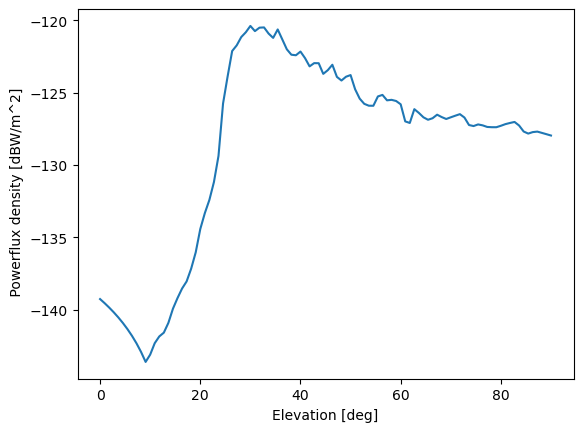

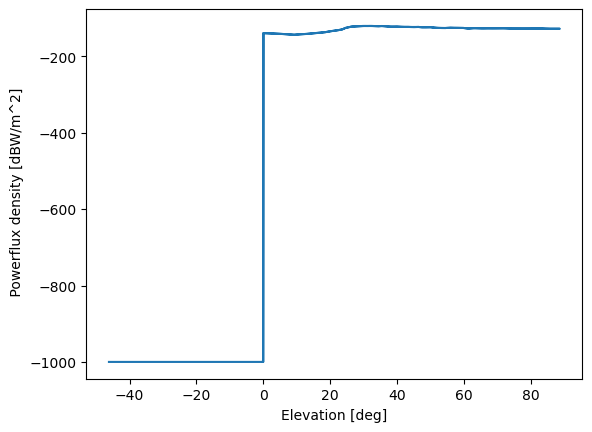

In [ ]:
el_response=pd.read_csv('starlink_statistical_pfd.csv')
x_el=el_response['el'].values
y_spfd=el_response['psd_dBW_m2_4khz'].values  ### spectral powerflux density

scale4khz=50e6/4e3 ###4kHz to 1 Hz 
print((1*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz))
###powerflux_nu = powerflux / bandwidth

y_pfd=(y_spfd*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz)*(scale4khz*u.Hz) ### powerflux density I think in dB units it's this log factor, maybe should change this methiod
y_pfd=y_pfd.to(cnv.dB_W_m2)
### double check if needed
plt.plot(x_el,y_pfd)
plt.ylabel(' Powerflux density [dBW/m^2]')
plt.xlabel('Elevation [deg]')
plt.show()

### interpolate to respective satellite elevation
satpwrpfd=np.interp(cand_alt,xp=x_el,fp=y_pfd)  ### use this to replace transmitter side pfd
satpwrpfd[cand_alt<0]=-1000*cnv.dB_W_m2

plt.plot(cand_alt,satpwrpfd)
plt.ylabel(' Powerflux density [dBW/m^2]')
plt.xlabel('Elevation [deg]')
plt.show()

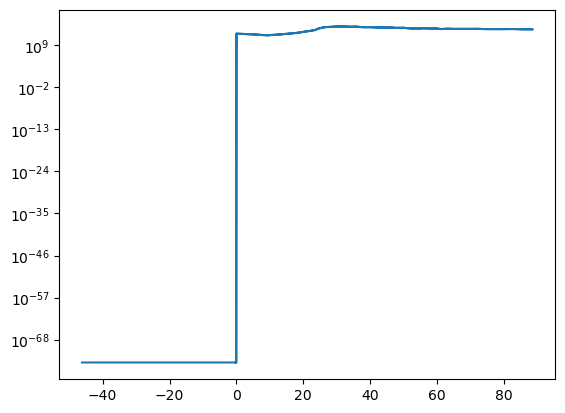

In [ ]:
skyflux=obs.pfd_to_Jy(satpwrpfd.value)
plt.plot(cand_alt,skyflux)
plt.yscale('log')
plt.show()

In [ ]:
### write the sky model
# column_names = ['RA', 'Dec', 'I', 'Q', 'U', 'V', 'freq0', 'spix', 'RM', 'maj', 'min', 'pa']
df.loc[1] ={}
for i in np.where(time_mask)[0]:
    # print(i)
    df.iloc[1,0]=cand_ra[i]
    df.iloc[1,1]=cand_dec[i]
    df.iloc[1,2]=skyflux[i]  ### replace the I flux with the pfd
    # print(df.to_csv( sep=' ', index=False, header=False, float_format='%.6g'))
    write_osm(df, 'sky_slices/sky_{}.osm'.format(i))


